# Crosshole traveltime tomography
We are doing a crosshole traveltime (e.g. seismics or GPR) tomography.
Assume two boreholes at x=0 and x=10m, with sources in the one and receivers
in the other, each with a spacing of 1m.
We discretize the subsurface by a 1x1m regular grid so that we can show
any model matrix just by `matshow`.

In [1]:
# define the grid by the node positions
x = 0:10;
y = 0:11;

We read a readily prepared raypath matrix (pyGIMLi notebook) which is a sparse matrix with the function `readdlm` into the integer positions i and j and the values v and create a sparse matrix.

In [2]:
using DelimitedFiles
using SparseArrays
IJV = readdlm("jacobian.ijv")
J = sparse(IJV[:, 1].+1, IJV[:, 2].+1, IJV[:, 3]);
# First we want to have a look at the matrix entries
using PyPlot
# use spy(J) to have a look at the matrix structure
G = Matrix(J);  # make a dense matrix of it

For matter of convenience, we create a function that displays any model vector (inclusive reshaping), typically with a fixed color scale and map, which can be deactivated by adding false.

In [3]:
nx = length(x) - 1
ny = length(y) - 1
function showModel(model, fixclim=true)
    matshow(transpose(reshape(model, nx, ny)))
    if fixclim
        clim(5, 25)
        set_cmap("Spectral_r")
    end
    colorbar();
    return
    end    
# Test it by showing a single ray
# showModel(G[9, :], false)
# plot([-0.5, 9.5], [0.5, 8.5], "k");

## Synthetic model

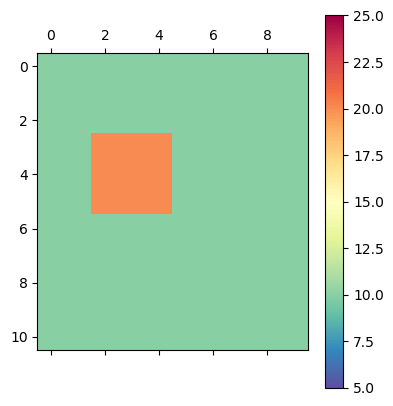

In [4]:
modelSyn = ones(nx, ny) * 10  # homogeneous
modelSyn[3:5, 4:6] .= 20  # anomaly
showModel(modelSyn[:])

In [5]:
# Next we create synthetic data with some random noise
using LinearAlgebra
d = G * modelSyn[:]
error = 1
d += randn(size(d)) * error;  # try also 0.3, 1, 3, 10
# showModel(pinv(G) * d)

## SVD-Inverse

Rank: 93 s[1]: 

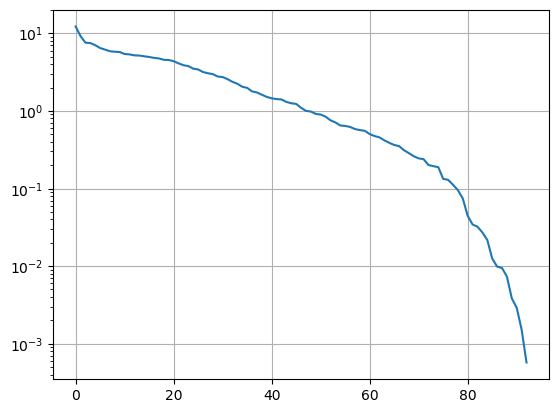

12.256104420332292 s[r]: 0.0005724840682208662

In [6]:
s = svd(G)
r = rank(G)
print("Rank: ", r, " s[1]: ", s.S[1], " s[r]: ", s.S[r])
semilogy(s.S[1:r])
grid()

The singular value spectrum shows that it is ill-posed
(i.e. small singular values - steep sv spectrum)

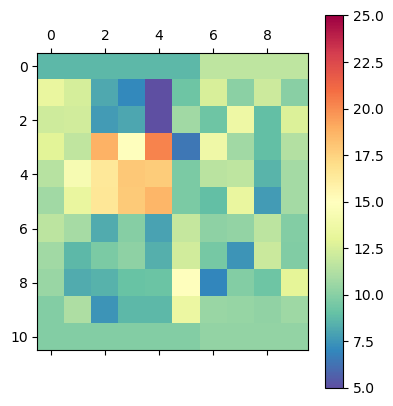

In [7]:
# We truncate small SV by rtol
model = pinv(G, rtol=0.01) * d
showModel(model)

In [20]:
model0 = ones(size(model)) .* 15
deltaData = d - G * model0
GS = G * diagm(model0)
deltaModel = pinv(GS, rtol=0.01) * deltaData
print(minimum(deltaModel), " ", maximum(deltaModel))
model = model0 .* exp(deltaModel)
showModel(model)

-0.7144744267952358 0.3504343571437313

MethodError: MethodError: no method matching exp(::Array{Float64,1})
Closest candidates are:
  exp(!Matched::BigFloat) at mpfr.jl:619
  exp(!Matched::Missing) at math.jl:1167
  exp(!Matched::Complex{Float16}) at math.jl:1115
  ...

### Resolution matrix

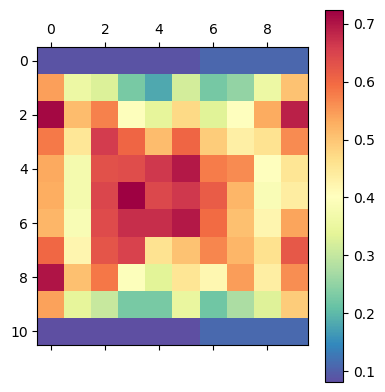

In [36]:
# Let us have a look at the resolution matrix
RM = pinv(G, rtol=0.1) * G
showModel(diag(RM), false)

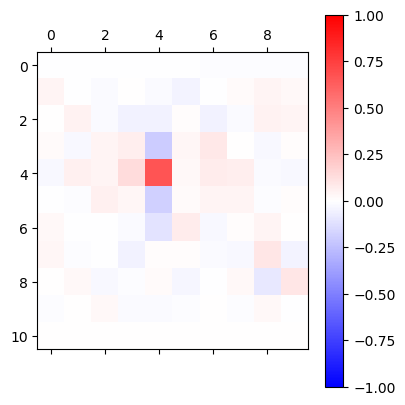

In [37]:
# Lets have a look at one column
showModel(RM[:, 10*4+5], false)  # 5th rows, 5th block
clim(-1, 1)
set_cmap("bwr")

### Tasks Part A 
For or all possible pseudoranks (1-93):

1. Compute the model using the truncated SVD inverse
1. Store the model norm in a vector
1. Store the residual norm in a vector
1. Compute the root-mean-square to the synthetic model

and plot those quantities over p.

Also plot the model norm against the residual norm and choose a `p` from these plots.

Which `p` has to be chosen according to the discrepancy principle?
(Compute the error-weighted misfit)

How does the resolution change with the optimum p?

Repeat the computations for two higher noise levels.

### Solution

The SVD inverse reads:
$${\bf m} = {\bf G}^\dagger {\bf d} = {\bf V}{\bf S}^{-1}{\bf U}^T {\bf d} = \sum_i \frac{U_i^T {\bf d}}{s_i} V_i $$
and can be truncated by
$${\bf m} = {\bf G}^\dagger {\bf d} = {\bf V_p}{\bf S_p}^{-1}{\bf U_p}^T {\bf d} = \sum_i^p \frac{U_i^T {\bf d}}{s_i} V_i = \sum_i \frac{f_i}{s_i}  U_i^T {\bf d} V_i $$


In [38]:
# The synthetic model (for easier playing with noise)
d = G * modelSyn[:]
error = 1.0  # try 0.1, 0.3, 1, 3, 10
d += randn(size(d)) * error  # add Gaussian random noise
GD = (1.0 ./ error) .* G
sD = svd(GD)
print("max(s) unscaled: ", maximum(s.S), ", scaled: ", maximum(sD.S))
# We choose the method of filter factors setting them to one or zero instead of cutting U/V
UTd = transpose(sD.U) * (d ./ error);  # U^T * d

max(s) unscaled: 12.256104420332292, scaled: 12.256104420332292

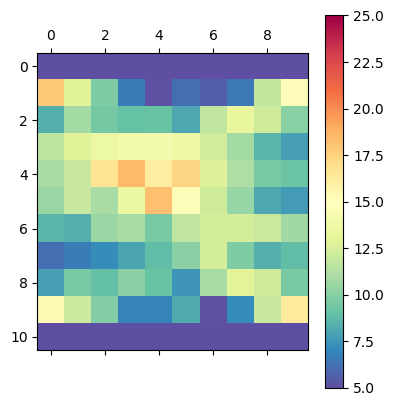

In [39]:
p = 20
f = zeros(size(sD.S))
f[1:p] .= 1.0
model = sD.V * (f ./ sD.S .* UTd)
showModel(model)

We use the chi-square measure:
$$\chi^2 = \frac{1}{N}\sum_i^N \left(\frac{d^{obs}_i-d^{syn}_i}{\epsilon_i}\right)^2=\frac{1}{N}\sum_i^N \hat{r}_i^2$$
$$\chi^2 = \frac{1}{N} \|{\bf\hat{r}}\|_2^2$$
A chi-square of 1 (a residual norm of $\sqrt{N}$) means the data are fitted within noise.

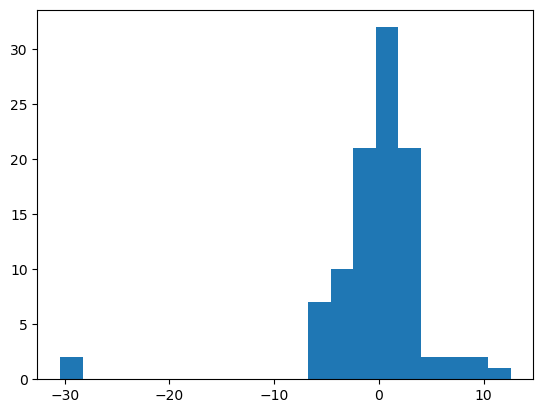

mean=-0.29746876744767875 std=5.3775399107696025 norm=53.58847245873648

In [40]:
using Statistics
f = zeros(length(s.S))
p = 36
f[1:p] .= 1.0  # increasingly set f to one
model = sD.V * (f ./ sD.S .* UTd)
residual = (G * model .- d) ./ error
print("mean=", mean(residual), " std=", std(residual), " norm=", norm(residual))
hist(residual, bins=20);

In [41]:
pMax = rank(G)
f = zeros(length(s.S))
modelNorm = zeros(pMax)
residualNorm = zeros(pMax)
chiSquare = zeros(pMax)
for p in 1:93
    f[p] = 1.0  # increasingly set f to one
    model = sD.V * (f ./ sD.S .* UTd)
    modelNorm[p] = norm(model)
    residual = (G * model - d) ./ error
    residualNorm[p] = norm(residual)
    chiSquare[p] = sum(residual.^2) / length(d)
end

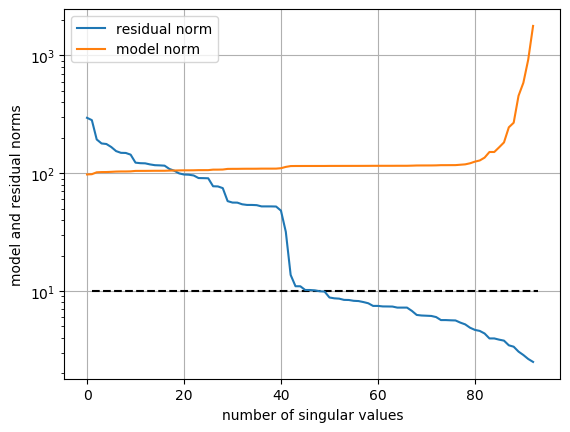

In [42]:
semilogy(residualNorm, label="residual norm")
semilogy(modelNorm, label="model norm")
hlines(sqrt(length(d)), 1, pMax, linestyles="dashed")
grid()
xlabel("number of singular values")
ylabel("model and residual norms")
legend();

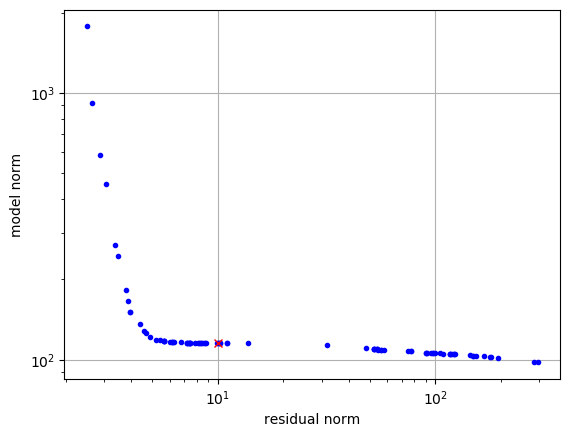

Optimum p after discrepancy principle: 49

In [44]:
pp = argmin(abs.(chiSquare .- 1))
print("Optimum p after discrepancy principle: ", pp)
loglog(residualNorm, modelNorm, "b.")
loglog(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

## Damped least squares
We now use the damped least squares solution

$$ {\bf m} = ({\bf G}^T {\bf G} + \lambda^2 {\bf I})^{-1} {\bf d} $$

It can also be expressed by SVD through a filtered sum
$$ {\bf m} = \sum_i \frac{s_i^2}{s_i^2+\lambda^2} \frac{U_i^T{\bf d}}{s_i} V_i = f_i \frac{U_i^T{\bf d}}{s_i} V_i $$
with the filter factors
$$ f_i = \frac{s_i^2}{s_i^2+\lambda^2} = \frac{1}{1+(\lambda_i/s_i)^2} $$

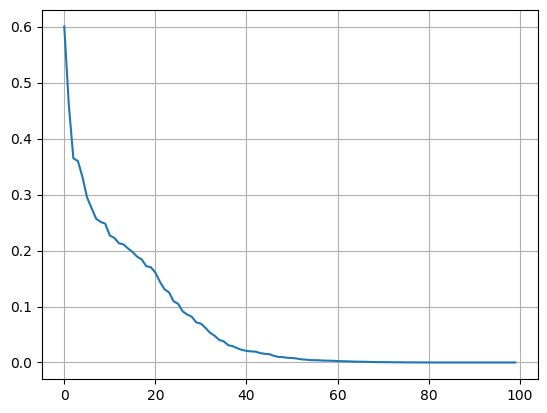

In [45]:
# Let's first have a look at the filter factors
lambda = 10  # then 1 and 0.1
lamByS = lambda ./ s.S
f = 1 ./ (lamByS.^2 .+ 1)
plot(f);
grid()
# It looks like a smooth truncation of singular values

We now look at the weighting functions
$$ \frac{s_i}{s_i^2+\lambda^2} = \frac{f_i}{s_i} $$
in comparison to the SVD weighting functions $1/s_i$

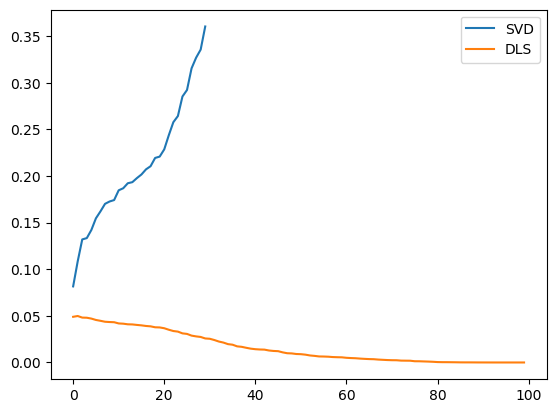

In [46]:
plot(1.0 ./ s.S[1:30], label="SVD")
plot(f ./ s.S, label="DLS")
legend();

### Task Part B
1. Create a logarithmically equidistant lambda vector
2. Do an interactive plotting (like above for pinv)
3. Plot the same quantities as above (model norm, residual norm) over $\lambda$ and against each other.
4. Which $\lambda$ do you choose according to the discrepancy principle?
5. Repeat with the same noise levels as above (try use same data).
6. Compute the resolution matrix and compare to TSVD

### Solution

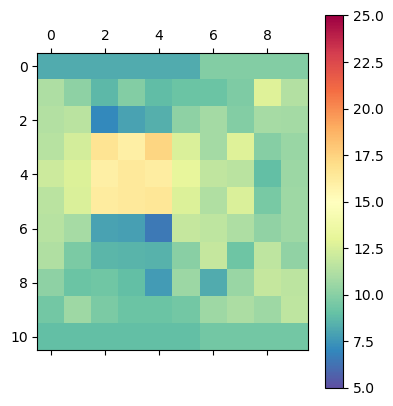

In [47]:
# Let's compute some solutions with different lambda
lambda = 0.5  # 10, 1, 0.1, 0.01
nM = size(G, 2)
IM = Matrix(I, nM, nM)  # identity matrix of size M
GT = transpose(G)
model = inv(GT * G + IM * lambda^2) * (GT * d)
showModel(model)

In [48]:
lambdaVector = 10 .^ range(-2, 2, step=0.1)  # log-equdist from 0.01 to +2
modelNorm = zeros(size(lambdaVector))
residualNorm = zeros(size(lambdaVector))
chiSquare = zeros(size(lambdaVector))
for i =  1:length(lambdaVector)
    lambda = lambdaVector[i]
    model = inv(GT * G + IM .* lambda^2) * (GT * d)
    modelNorm[i] = norm(model)
    residual = (G * model - d) ./ error
    residualNorm[i] = norm(residual)
    chiSquare[i] = sum(residual.^2) / length(d)    
end

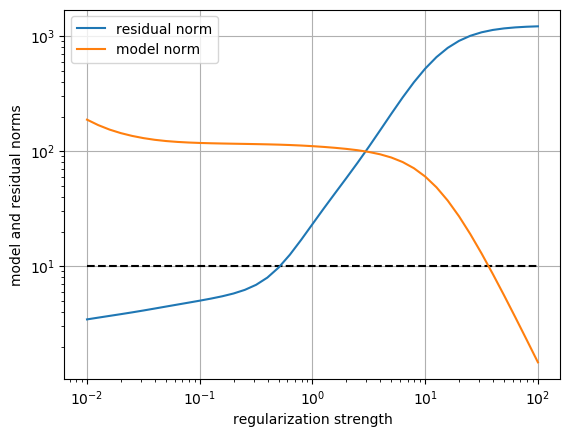

In [49]:
loglog(lambdaVector, residualNorm, label="residual norm")
loglog(lambdaVector, modelNorm, label="model norm")
hlines(sqrt(length(d)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

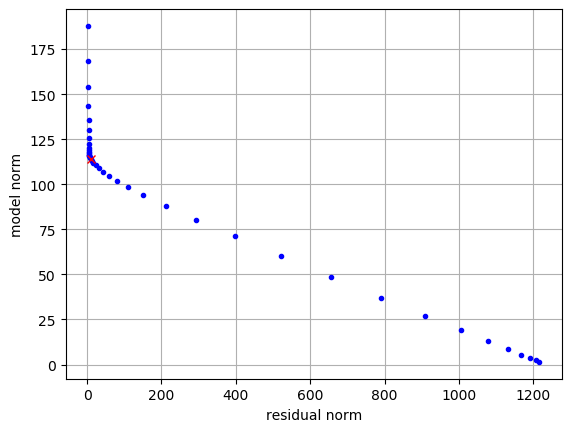

Optimum lambda after discrepancy principle: 0.5011872336272722

In [50]:
pp = argmin(abs.(chiSquare .- 1))
print("Optimum lambda after discrepancy principle: ", lambdaVector[pp])
plot(residualNorm, modelNorm, "b.")
plot(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

## Smoothness constraints
### Task Part C
Define a roughness operator (see talk), e.g.: 
- How many model boundaries are in the model? Define a zero matrix!
- Run through all cells with a right neighbor and insert a -1 and a +1
- Run through all cells with a lower neighbor and insert a -1 and a +1
Replace the identity matrix by this matrix and repeat the previous steps (damped least squares) by using smoothness constraints.

### Definition of smoothness matrices

In [74]:
# Let us first check in which order the cells are numbered
# showModel(1:length(model), false)

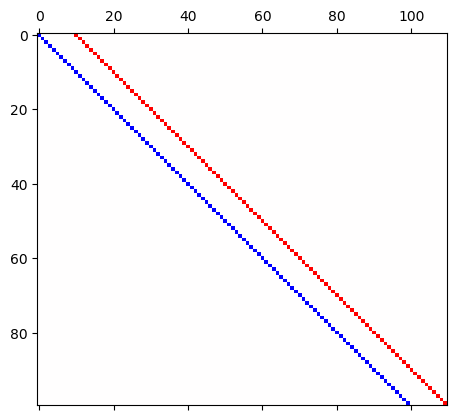

In [52]:
# all y directed boundaries
Cy = zeros(nx*(ny-1), nx*ny)
for i = 1:nx*(ny-1)
    Cy[i, i] = -1
    Cy[i, i+nx] = +1
end
matshow(Cy)
set_cmap("bwr")

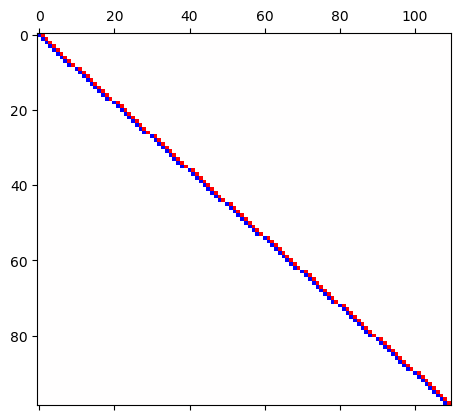

In [53]:
# now all x directed boundaries
Cx = zeros((nx-1)*ny, nx*ny)
ind = 0
for iy = 1:ny
    for ix = 1:nx-1
        ind += 1  # count upwards
        i = (iy-1)*nx + ix
        Cx[ind, i] = -1
        Cx[ind, i+1] = +1
    end
end
matshow(Cx)
set_cmap("bwr")

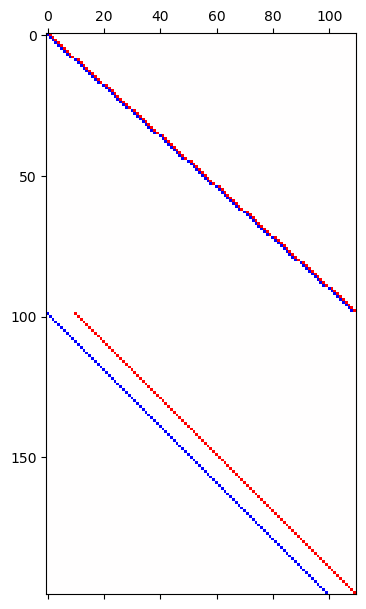

In [54]:
C = vcat(Cx, Cy)
matshow(C)
set_cmap("bwr")

### Solution and misfit

5.122536224406788

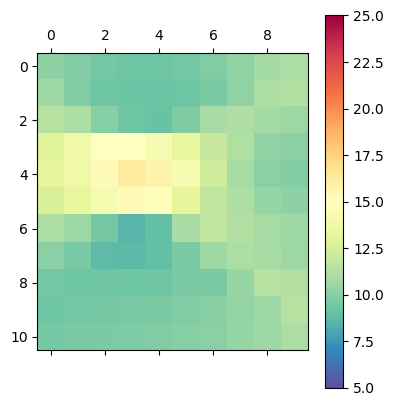

In [58]:
# Let's compute some solutions with different lambda
lambda = 2  # 10, 1, 0.1  -> 0.77
GDT = transpose(GD)
model = inv(GDT * GD + transpose(C) * C .* lambda^2) * (GDT * (d ./ error))
residual = (G * model - d) ./ error
display(sum(residual.^2) / length(d))  # 
showModel(model)

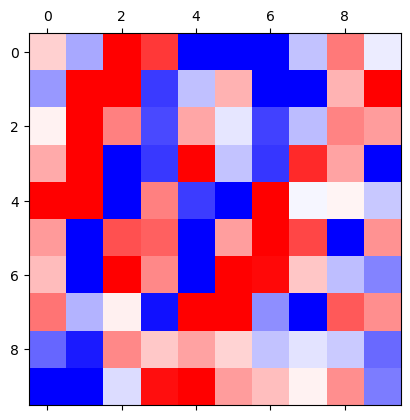

In [59]:
misfit = (G * model - d) ./ error
matshow(reshape(misfit, (10, 10)));
clim(-2, 2)
set_cmap("bwr")

### Regularization strength $\lambda$

In [48]:
lambdaVector = 10 .^ range(-2, 2, step=0.1)  # log-equdist from 0.01 to +2
modelNorm = zeros(size(lambdaVector))
residualNorm = zeros(size(lambdaVector))
chiSquare = zeros(size(lambdaVector))
for i =  1:length(lambdaVector)
    lambda = lambdaVector[i]
    model = inv(GDT * GD + transpose(C) * C .* lambda^2) * (GDT * (d ./ error))
    modelNorm[i] = norm(model)
    residual = (G * model - d) ./ error
    residualNorm[i] = norm(residual)
    chiSquare[i] = sum(residual.^2) / length(d)    
end

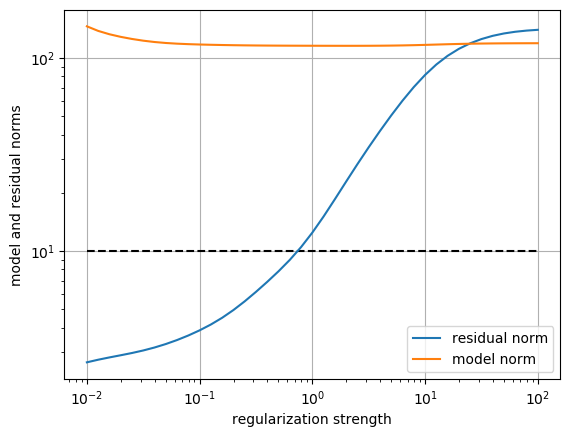

In [49]:
loglog(lambdaVector, residualNorm, label="residual norm")
loglog(lambdaVector, modelNorm, label="model norm")
hlines(sqrt(length(d)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

### Resolution matrices

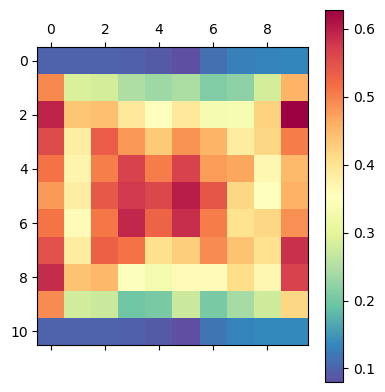

In [50]:
# Resolution matrix
lambda = 0.77  # 10, 1, 0.1
GTG = transpose(GD) * GD
CTC = transpose(C) * C
RM = inv(GTG + CTC .* lambda^2) * (GTG)
showModel(diag(RM), false)
set_cmap("Spectral_r")

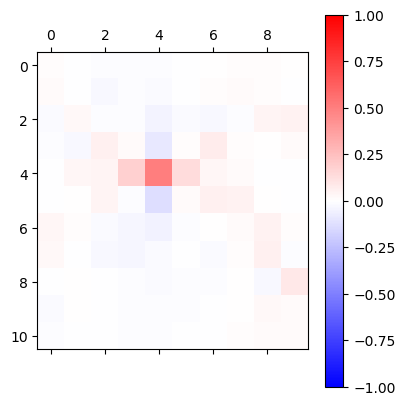

In [51]:
showModel(RM[:, 4*10+5], false)
clim(-1, 1)
set_cmap("bwr")

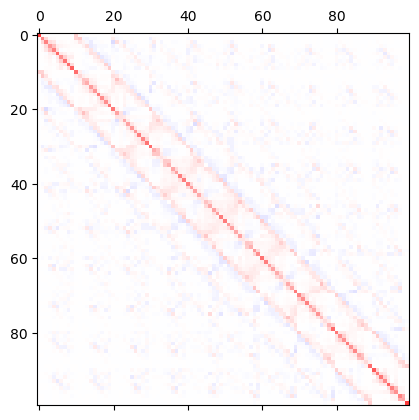

In [67]:
# Data Resolution matrix
lambda = 0.77  # 10, 1, 0.1
GTG = transpose(GD) * GD
CTC = transpose(C) * C
RD = GD * inv(GTG + CTC .* lambda^2) * transpose(GD)
matshow(RD)
clim(-1, 1)
set_cmap("bwr")

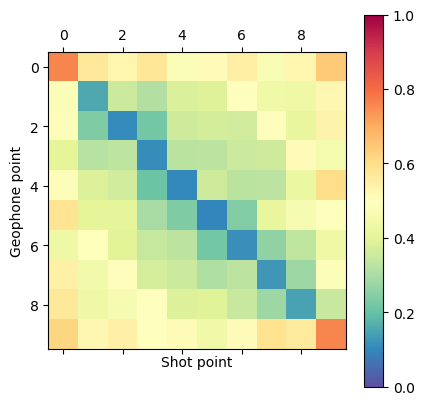

In [68]:
# The diagonal holds the individual data importance
matshow(reshape(diag(RD), (10, 10)));
clim(0, 1)
set_cmap("Spectral_r")
colorbar()
xlabel("Shot point")
ylabel("Geophone point");

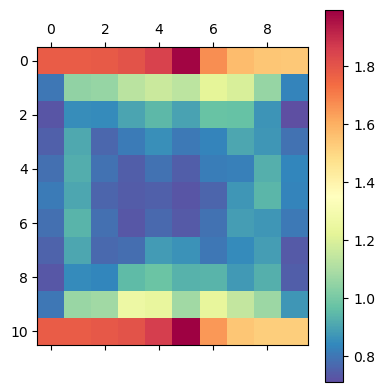

In [52]:
resrad = sqrt.(1 ./ diag(RM)./pi)
showModel(resrad, false)
set_cmap("Spectral_r")